# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
#n_train = ?

# TODO: Number of testing examples.
#n_test = ?

# TODO: What's the shape of an traffic sign image?
#image_shape = ?

# TODO: How many unique classes/labels there are in the dataset.
#n_classes = ?

from sklearn.model_selection import train_test_split
from skimage import data

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of test examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 31367
Number of validation examples = 7842
Number of test examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

29


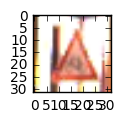

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
### shuffle the training data.
from sklearn.utils import shuffle
#import cv2 <-- used with gray scale test

def normalize_grayscale(image_data):
    a = -1.0
    b = 1.0
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_train = normalize_grayscale(X_train)
X_validation = normalize_grayscale(X_validation)
X_test = normalize_grayscale(X_test)

X_train, y_train = shuffle(X_train, y_train)
X_validation, y_validation = shuffle(X_validation, y_validation)
X_test, y_test = shuffle(X_test, y_test)

In [11]:
### setup tensor flow
import tensorflow as tf

EPOCHS = 10
#EPOCHS = 20
#BATCH_SIZE = 128
BATCH_SIZE = 64
# keep_prob is used for dropout
keep_prob = tf.placeholder(tf.float32)

In [12]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    #sigma = 0.1
    sigma = 0.05
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x16. try 3x3.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: Convolutional. input = 30x30x16. Output = 28x28x32. try 3x3.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


    # Layer 3: Convolutional. Output = 14x14x32, Output = 10x10x64. 5x5
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv3)
    
    # Fully Connected. Input = 1600. Output = 800.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 800), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(800))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
     
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Fully Connected. Input = 800. Output = 125.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(800, 125), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(125))
    fc2    = tf.matmul(fc1,fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # Fully Connected. Input = 125. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(125, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
#x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [14]:
### training pipeline
rate = 0.001
#rate = 0.0001
#rate = 0.003

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
### model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
### train the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'hk_model.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.934

EPOCH 2 ...
Validation Accuracy = 0.978

EPOCH 3 ...
Validation Accuracy = 0.984

EPOCH 4 ...
Validation Accuracy = 0.975

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.986

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.983

EPOCH 9 ...
Validation Accuracy = 0.989

EPOCH 10 ...
Validation Accuracy = 0.989

Model saved


In [17]:
### Evaluate the model with test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, 'hk_model.ckpt')

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.950


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

At first, I just used shuffle() for preprocessing. I tried changing the training pics to gray but it didn't seem to improve the accuracy so I decided to remove that part of code.   
But when I submit this project once, there was a suggestion about applying "normalization" so I tried and seems to improve the accuracy.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I used 20% of the training data as the validation.  

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

conv1 -> RELU -> conv2 -> RELU -> max. pool -> conv3 -> RELU -> max. pool -> (flattern) -> FC -> dropout -> RELU ->  FC -> RELU -> FC

conv1: input 32x32x6, output 30x30x16, filter 3x3
conv2: input 30x30x16, output 28x28x32, filter 3x3
pool: input 28x28x32, output 14x14x32
conv3: input 14x14x32, output 10x10x64, filter 5x4
pool: input 10x10x64, output 5x5x64
fc: 600x120
fc: 120x84
fc: 84x43


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I tried changing with learning rate, epochs, and batch size many times.  In the end, I picked:
learning rate = 0.001
epochs = 20
batch size = 68
sigma = 0.05

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I first implemented the code I did for the LeNet project in Lesson 10.  I used that as a guideline and tried to improve the model.  My approach is a process of trail and error.  I looked at the training accuracy value and decided if I wanted to change or not.

My approach was as follows:
 
(1) first I tried changing learning rate, epochs and batch size, because they are something I could change easily.  I change around these values every time I changed other part of the model.
(2) next I investigated convolution layers.  I tried using a 3x3 filter for first two layers and add one more layer (note: I wanted to add max. pool after each layer but the size becaume odd x odd numbers and I didn't know if I could do it.  I just add another layer without max pool).  I also tried to just simply add one more layer with 5x5 filter but it didn't improve the accuracy.  So I decided to keep 3x3 filter.
(3) I changed the number of maps in the convolution layers.  For example, for the first layer, instead of using output 28x28x6, I tried 28x28x12, and so on.  
(4) I added one more layer for full-connected part.  Also, tried to change the dimension in the hidden layers.  But decided to use three layers in the end.   
(5) I also added dropout in FC layers.

This is the order I started but I actually went back and forth changing around all the stuff in steps (1)-(5) many times.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

14


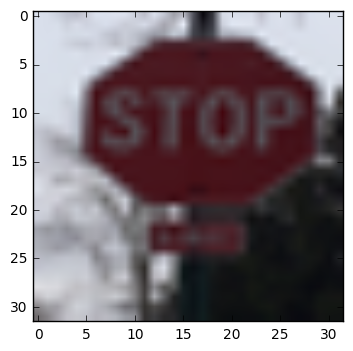

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy import misc

my_images = []
def prepare_image(png_file):
    image = misc.imread(png_file)
    #image = np.delete(image, 3, 2) 
    resized = cv2.resize(image, (32, 32))
    #img = mpimg.imread(png_file)
    #resized = np.delete(img, 3, 2)
    my_images.append(resized)
    #my_images.append(tf.image.resize_images(resized, (32, 32)))

#def prepare_image(png_file):
#    image = mpimg.imread(png_file)
#    print(image)
#    #image = np.delete(image, 3, 2) 
#    resized = cv2.resize(image, (32, 32))
#    #img = mpimg.imread(png_file)
#    #resized = np.delete(img, 3, 2)
#    my_images.append(resized)
#    #my_images.append(tf.image.resize_images(resized, (32, 32)))

prepare_image('stop3.png')
prepare_image('right_turn_3.png')
prepare_image('left_turn_3.png')
prepare_image('turn_right.png')
prepare_image('speed_limit_40_3.png')

#image2 = mpimg.imread('speed_limit_40_3.png')
#image2_shape = image2.shape
#print(image2_shape)


my_images_label=[14, 33, 34, 33, 51] # speed limit signs are not included in training

#%matplotlib inline

#index = random.randint(0, len(my_images)-1)
plt.imshow(my_images[0])
print(my_images_label[0])


33


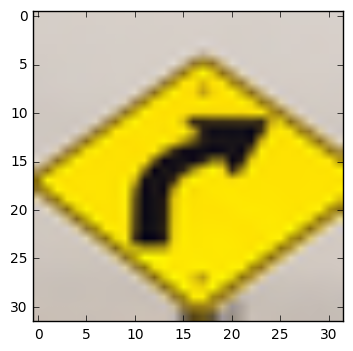

In [19]:
plt.imshow(my_images[1])
print(my_images_label[1])

34


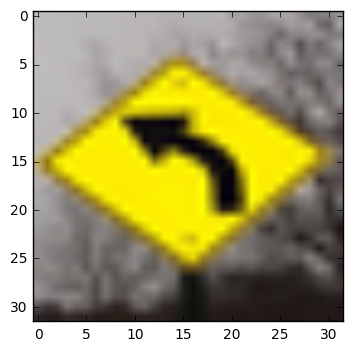

In [20]:
plt.imshow(my_images[2])
print(my_images_label[2])

33


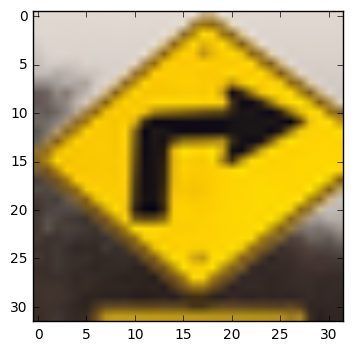

In [21]:
plt.imshow(my_images[3])
print(my_images_label[3])

51


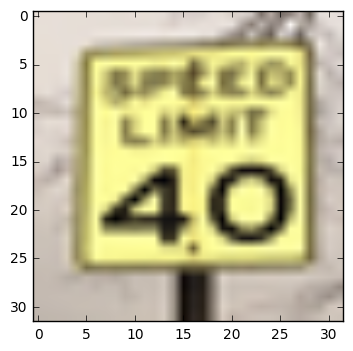

In [22]:
plt.imshow(my_images[4])
print(my_images_label[4])

In [23]:
for i in range(0,5):
    my_images[i]= normalize_grayscale(my_images[i])


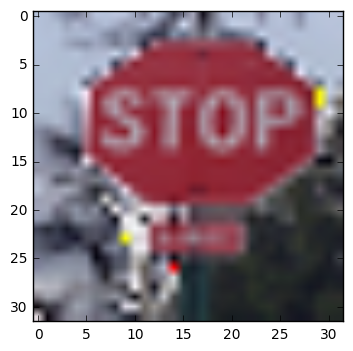

In [24]:
plt.imshow(my_images[0])

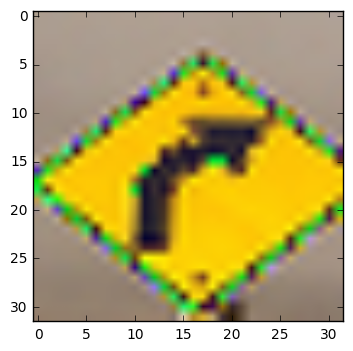

In [25]:
plt.imshow(my_images[1])

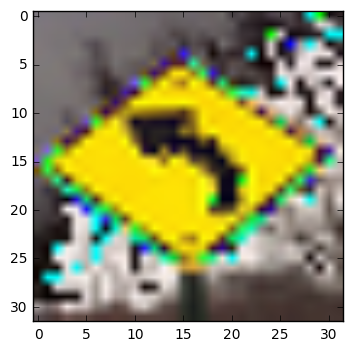

In [26]:
plt.imshow(my_images[2])

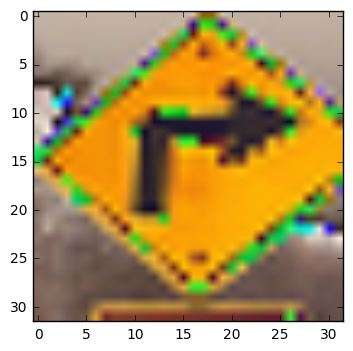

In [27]:
plt.imshow(my_images[3])

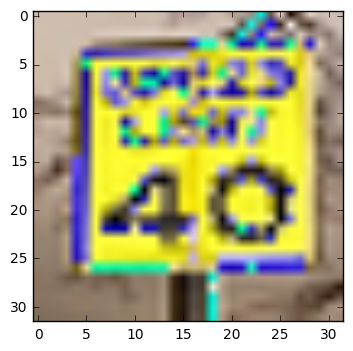

In [28]:
plt.imshow(my_images[4])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



The traffic images are shown above.
I have:
(1) stop sign, (2) mild curve to right, (3) mild curve to left, (4) turn right, and (5) 40 mph speed limit.

I know the last one would be hard because we don't have 40 mph (or 40 kph) sign in the training set.  The shapes of the signs for (2)-(4) are diamond (or shall I say, the square turned 45 deg.) shape and I was wondering that gives a problem of recognizing the sign correctly.  

In [29]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
### Evaluate the model with test data

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))  
    pred = tf.nn.softmax(logits)
    #pred = tf.argmax(tf.nn.softmax(logits), 1)
    new_predictions = sess.run(pred, feed_dict={x:my_images, keep_prob:1.0})
    #sign_pred = tf.argmax(pred, 1)
    print(new_predictions)
    #print(new_predictions)

[[  1.05827704e-14   1.01080468e-08   1.12216869e-09   6.93313407e-09
    8.48941098e-19   6.11951023e-08   1.33390391e-11   8.85454938e-07
    4.96422126e-10   7.04151262e-08   6.28256248e-06   1.68991799e-04
    9.99817908e-01   1.80060579e-06   1.34087736e-08   3.43113560e-09
    2.59423008e-08   8.13285481e-11   2.39053291e-11   2.89278353e-14
    2.82810598e-11   1.55390159e-10   1.44554134e-18   1.63606517e-10
    7.67364370e-18   3.19793497e-11   6.98168945e-09   2.46078233e-15
    1.87614444e-06   5.22480659e-13   1.50020413e-10   1.76308860e-15
    5.59428344e-08   8.64353585e-15   3.03087590e-11   1.13600405e-11
    1.38425363e-13   4.20696057e-14   1.20373911e-09   7.44190124e-16
    1.62039683e-07   8.57124416e-09   1.92421840e-06]
 [  4.11041081e-04   2.22197268e-03   2.79947645e-11   8.53925758e-06
    2.87881807e-09   7.85078795e-04   1.63253799e-06   1.02062188e-06
    3.70466523e-06   1.07280823e-06   4.50209541e-08   2.29400157e-05
    8.65359561e-06   3.21165011e-10 

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


### My answer ###
It doesn't look like the model predicted the sign correctly.  I have a 40 mph speed limit sign and since this was not in the trainign set, I didn't think the model would accurately predict them.  However, I was hoping that my model could predict the rest of the signs but the model didn't.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [32]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))  
    pred = tf.nn.softmax(logits)
    top_3 = tf.nn.top_k(pred, 3)
    top3_answer = sess.run(top_3, feed_dict={x:my_images, keep_prob:1.0})
    print(top3_answer)

TopKV2(values=array([[  9.99817908e-01,   1.68991799e-04,   6.28256248e-06],
       [  9.38256204e-01,   2.73310319e-02,   2.60676686e-02],
       [  9.94207382e-01,   5.78333670e-03,   4.78653374e-06],
       [  9.46304619e-01,   4.36400734e-02,   6.45773346e-03],
       [  6.66423917e-01,   1.81206882e-01,   1.13223389e-01]], dtype=float32), indices=array([[12, 11, 10],
       [20, 17, 32],
       [ 8,  7,  4],
       [13, 17, 36],
       [30, 20, 25]], dtype=int32))


###My Answer to Question 8:
These are the reasons I picked my five images: I thought I should include STOP sign because it looks like almost same as the German stop sign.  I chose KEEP RIGHT, KEEP LEFT and TURN RIGHT because I thought the model might recongnize the arrow easily.  The last one I picked was 40 MPH speed limit.  Since there was no number 40 available, I didn't think the model would accurately picked up.

My first sign, STOP sign, was not predicted accurately.  Maybe it is because the quality of my picture is not good?  It picked 12 = Priority road as a highest probablity. This was the highet among three (the first one is close to 1.0 and others are the order of e-04 and e-06) and I think that means this prediction is pretty certain.  Yet, this is a wrong sign.  

For the second sign, KEEP RIGHT, it picked 20 = Dangerous curve to the right.  This is close as my sign has the arrow goes to right.  The number one probablity is higher than other two.

For the third sign, KEEP LEFT, all top 3 are something to do with speed limit.  Even though, the top one has a pretty good probability, this didn't seem predict well.

For the fourth sign, TURN RIGHT, it picked 13 = yield.  This also seems to have higher probability the other, even though it didn't predict correctly.

For the fifth sign, SPEED LIMIT 40 MPH, it picked 30 = Beware of ice/snow.  I was hoping the model at least pick a sign with a number but it didn't.

##Some other comments:

Although, the top probability is pretty high (close to 1.0) for most of my images which indicates certainty, the prediction was not accurate at all using human eyes (except the second "KEEP RIGHT" image).  I can think several reasons why the model did not predict well:

(1) some of my images have background.  For example, my KEEP LEFT and STOP SIGN seems to have background and it might have given some sort of noise.  

(2) it might be picking the "shape" of the sign itself better than actual sign content such as an arrow or a number.  For example, for my SPEED LIMIT 40 MPH sign, it didn't pick any German SPEED LIMIT sign. Instead, it seems to pick all the triangle shape ones to the top 3 picks.  My SPEED LIMIT sign is a rectangle and the German SPEED LIMIT sign is a circle.  My model thought a triangle is closer to a rectangle.

(3) 4 out of 5 of my images have yellow color. There are not many yellow traffic signs in the training set, and that might have something to do with prediction inaccuracy.  Converting the sign to gray scale seems to be a good idea here. I tried using gray scale but I didn't see the accuracy improve.  I might have applied wrongly.  It is certainly something I would like to play with.  
    




> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.